In [1]:
# import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using Plots
using TrajOptPlots
using StaticArrays
using SparseArrays
using Printf
using Test
using PrettyTables

Drone Parameters

In [2]:
m = 0.027; # kg
g = 9.81; # m / s ^2
l = 0.046; # m
Ix = 1.66e-5; # kg m ^2
Iy = 1.66e-5; # kg m ^2
Iz = 2.93e-5; # kg m ^2

I = Diagonal([Ix, Iy, Iz]);
inv_I = Diagonal([1 / Ix, 1 / Iy, 1 / Iz]);

kf = 2.2e-8; # kg m / rad^2
km = 2e-9;

Nx = 12; # States
Nu = 4; # Inputs

Functions

In [3]:
function rpy2rot(r, p, y)
    R_r = [1 0 0; 0 cos(r) -sin(r); 0 sin(r) cos(r)]
    R_p = [cos(p) 0 sin(p); 0 1 0; -sin(p) 0 cos(p)]
    R_y = [cos(y) -sin(y) 0; sin(y) cos(y) 0; 0 0 1]
    return R_y * R_p * R_r
end;

function pqr2rpydot(r, p, y, omega_p, omega_q, omega_r)
    E = [1 (sin(r) * tan(p)) (cos(r) * tan(p)); 0 cos(r) -sin(r); 0 (sin(r) / cos(p)) (cos(r) / cos(p))]
    omega_w = E * [omega_p; omega_q; omega_r]
    return omega_w
end;

Dynamics

In [4]:
function drone_dynamics(x, u)
    u1 = u[1]
    u2 = u[2]
    u3 = u[3]
    u4 = u[4]
    
    phi = x[4]
    theta = x[5]
    psi = x[6]
    
    p = x[10]
    q = x[11]
    r = x[12]
    
    pqr = [p; q; r]
    
    R = rpy2rot(phi, theta, psi)
    
    xyz_ddot = (1 / m) * ([0; 0; -m * g] + R * [0; 0; u1])
    rpy_dot = pqr2rpydot(phi, theta, psi, p, q, r)
    pqr_dot = inv_I * ([u2; u3; u4] - cross(pqr, I * pqr))
    
    x_next = [x[7:9]; rpy_dot; xyz_ddot; pqr_dot]
    return x_next
end;

RK4

In [5]:
function drone_dynamics_RK4(x, u, h)
    f1 = drone_dynamics(x, u)
    f2 = drone_dynamics(x + 0.5 * h * f1, u)
    f3 = drone_dynamics(x + 0.5 * h * f2, u)
    f4 = drone_dynamics(x + h * f3, u)
    xn = x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    
    return xn
end;

Riccati Equations

In [6]:
function riccati(A, B, Q, R)
    Nx, Nu = size(B)
    P = zeros(Nx, Nx)
    K = zeros(Nu, Nx)
    K_old = zeros(Nu, Nx)
    P .= Q
    for i = 1:1000
        K .= (R + (B' * P * B)) \ (B' * P * A)
        P .= Q + A' * P * (A - B * K)
        if (norm(K - K_old) < 1e-6)
            break
        end
        K_old .= K
    end
    
    return K
end;

Linearization

In [7]:
x_hover = zeros(Nx)
u_hover = zeros(Nu)

x_hover[3] = 0.5;
u_hover[1] = m * g;

h = 0.002; # Discritization

A_hover = ForwardDiff.jacobian(x -> drone_dynamics(x, u_hover), x_hover);
B_hover = ForwardDiff.jacobian(u -> drone_dynamics(x_hover, u), u_hover);

A_d = ForwardDiff.jacobian(x -> drone_dynamics_RK4(x, u_hover, h), x_hover);
B_d = ForwardDiff.jacobian(u -> drone_dynamics_RK4(x_hover, u, h), u_hover);

LQR Gains

In [8]:
Q = Diagonal([2.5, 2.5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1]);
R = Diagonal([100, 15000, 15000, 15000]);

K = riccati(A_d, B_d, Q, R);

In [9]:
x_T = zeros(Nx);
x_T[1] = 0.25;
x_T[2] = -0.25;
x_T[3] = 0.5;

x_init = zeros(Nx);
x_init[1] = 0.05;
x_init[2] = 0.1;
x_init[3] = 0.0;

u_init = u_hover;

T = 5;
Nt = Int(T / h) + 1

uhist = repeat(u_hover, 1, Nt - 1)
xhist = zeros(Nx, Nt);

xhist[:, 1] = x_init;

In [10]:
for k = 1:(Nt-1)
    e_x = xhist[:, k] - x_T
    uhist[:, k] -= (K * e_x) 
    xhist[:, k + 1] = drone_dynamics_RK4(xhist[:, k], uhist[:, k], h)
end

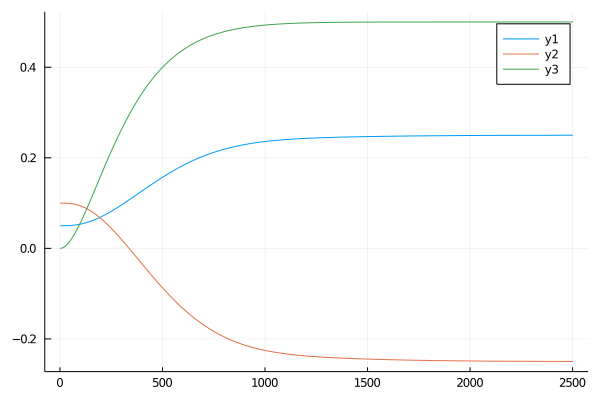

In [11]:
plot(xhist[1, :])
plot!(xhist[2, :])
plot!(xhist[3, :])

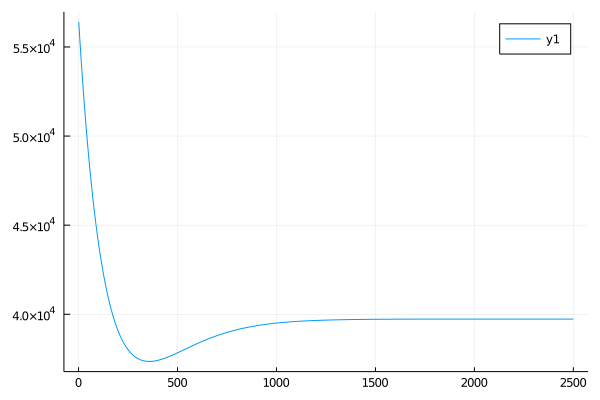

In [12]:
plot(uhist[1, :])

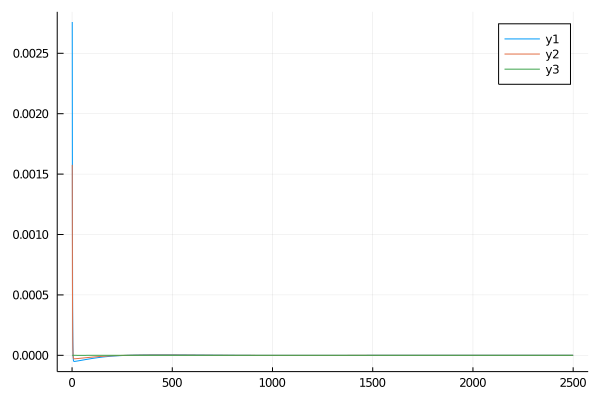

In [13]:
plot(uhist[2, :]*1.00000)
plot!(uhist[3, :]*1.00000)
plot!(uhist[4, :]*1.00000)